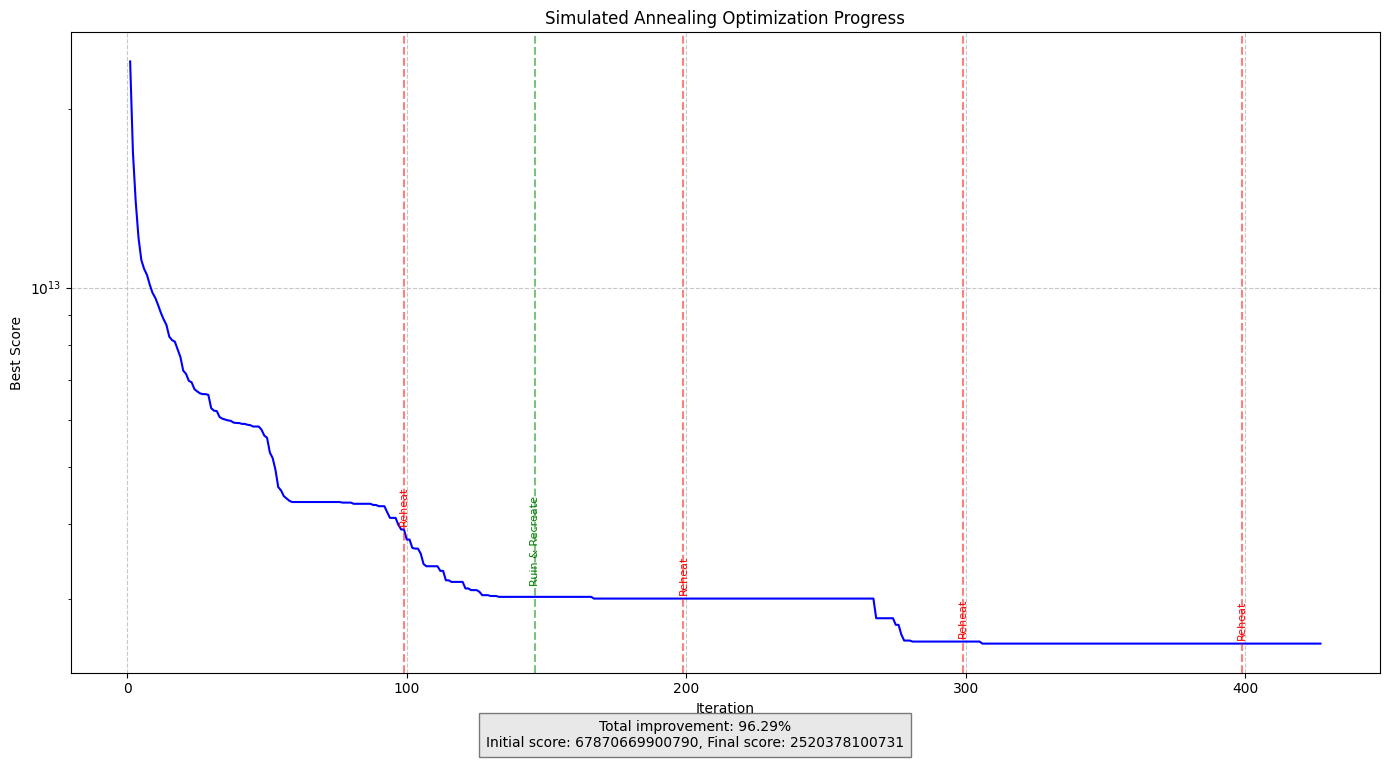

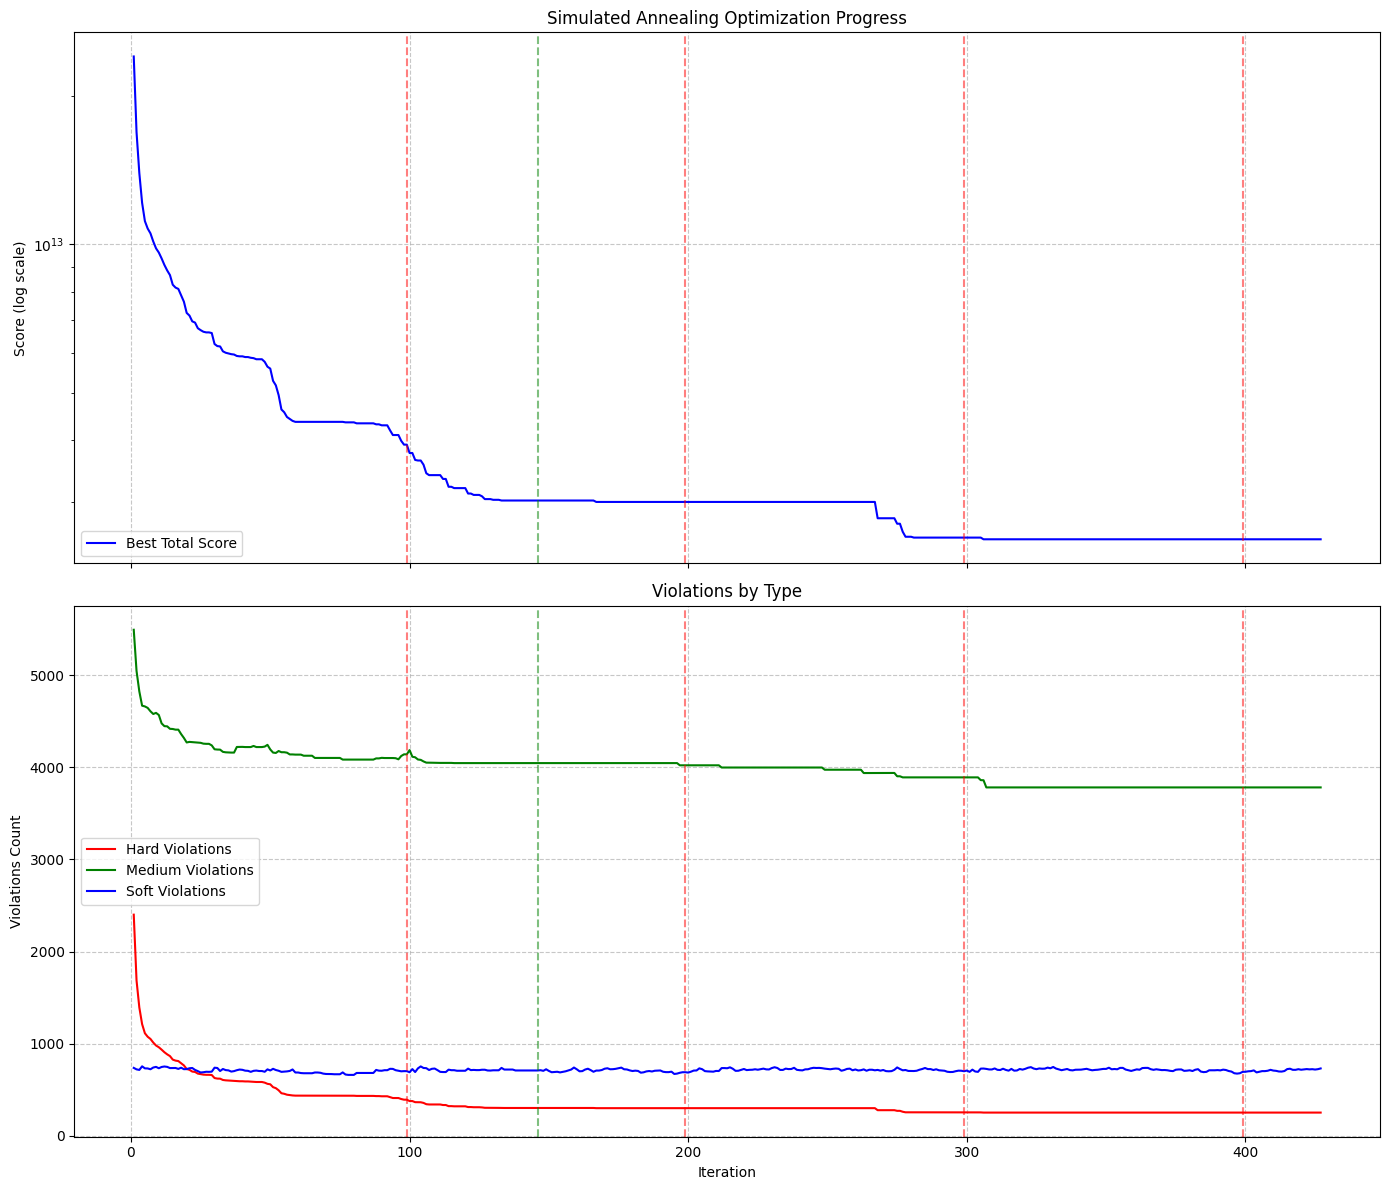

In [12]:
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
import os

def parse_annealing_log(log_text):
    """Parse the log file to extract iteration, best score, and special events."""
    lines = log_text.strip().split('\n')
    
    # Initialize data structures
    initial_score = None
    iterations = []
    best_scores = []
    reheating_iterations = []
    ruin_iterations = []
    
    current_iteration = None
    
    for line in lines:
        # Match iteration lines
        initial_score_match = re.search(r'Initial score: (\d+)', line)
        if initial_score_match:
            initial_score = int(initial_score_match.group(1))
        
        iteration_match = re.search(r'Iteration: (\d+),.*Best: (\d+)', line)
        if iteration_match:
            iteration = int(iteration_match.group(1))
            best_score = int(iteration_match.group(2))
            iterations.append(iteration)
            best_scores.append(best_score)
            current_iteration = iteration
        
        # Detect reheating
        if "Reheating" in line and current_iteration is not None:
            reheating_iterations.append(current_iteration)
        
        # Detect ruin and recreate
        if "Large plateau detected! Applying Ruin and Recreate" in line and current_iteration is not None:
            ruin_iterations.append(current_iteration)
    
    return {
        'initial_score': initial_score,
        'iterations': iterations,
        'best_scores': best_scores,
        'reheating_iterations': reheating_iterations,
        'ruin_iterations': ruin_iterations
    }

def plot_annealing_progress(data):
    """Create a visualization of the annealing progress."""
    plt.figure(figsize=(14, 8))
    
    # Plot best score over iterations
    plt.plot(data['iterations'], data['best_scores'], 'b-', linewidth=1.5, label='Best Score')
    
    # Mark reheating events
    for reheat_iter in data['reheating_iterations']:
        idx = data['iterations'].index(reheat_iter)
        plt.axvline(x=reheat_iter, color='r', linestyle='--', alpha=0.5)
        plt.text(reheat_iter, data['best_scores'][idx]*1.02, 'Reheat', 
                 rotation=90, color='r', fontsize=8, ha='center')
    
    # Mark ruin and recreate events
    for ruin_iter in data['ruin_iterations']:
        idx = data['iterations'].index(ruin_iter)
        plt.axvline(x=ruin_iter, color='g', linestyle='--', alpha=0.5)
        plt.text(ruin_iter, data['best_scores'][idx]*1.05, 'Ruin & Recreate', 
                rotation=90, color='g', fontsize=8, ha='center')
    
    # Calculate improvement percentage
    if data['best_scores']:
        initial_score = data['initial_score']
        final_score = data['best_scores'][-1]
        improvement = ((initial_score - final_score) / initial_score) * 100
        
        plt.figtext(0.5, 0.01, f'Total improvement: {improvement:.2f}%\n'
                   f'Initial score: {initial_score}, Final score: {final_score}',
                   ha='center', fontsize=10, bbox={'facecolor':'lightgray', 'alpha':0.5, 'pad':5})
    
    # Add labels and title
    plt.xlabel('Iteration')
    plt.ylabel('Best Score')
    plt.title('Simulated Annealing Optimization Progress')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Optional: Log scale for y-axis if scores vary greatly
    plt.yscale('log')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for the text at the bottom
    plt.savefig('annealing_progress.png', dpi=300)
    plt.show()

# Function to break down score components
def plot_score_components(data, log_text):  # Added log_text parameter
    """Create an additional plot showing the breakdown of score components."""
    # Extract hard, medium, soft violations from the log
    hard_violations = []
    medium_violations = []
    soft_violations = []
    
    for i, iteration in enumerate(data['iterations']):
        # Find the corresponding line in the log
        match = re.search(rf'Iteration: {iteration},.*\(Hard: (\d+), Medium: (\d+), Soft: (\d+)\)', log_text)
        if match:
            hard = int(match.group(1))
            medium = int(match.group(2))
            soft = int(match.group(3))
            hard_violations.append(hard)
            medium_violations.append(medium)
            soft_violations.append(soft)
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
    
    # Plot total score
    ax1.plot(data['iterations'], data['best_scores'], 'b-', linewidth=1.5, label='Best Total Score')
    ax1.set_yscale('log')
    ax1.set_ylabel('Score (log scale)')
    ax1.set_title('Simulated Annealing Optimization Progress')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()
    
    # Plot components
    ax2.plot(data['iterations'], hard_violations, 'r-', linewidth=1.5, label='Hard Violations')
    ax2.plot(data['iterations'], medium_violations, 'g-', linewidth=1.5, label='Medium Violations')
    ax2.plot(data['iterations'], soft_violations, 'b-', linewidth=1.5, label='Soft Violations')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Violations Count')
    ax2.set_title('Violations by Type')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()
    
    # Mark events on both plots
    for reheat_iter in data['reheating_iterations']:
        ax1.axvline(x=reheat_iter, color='r', linestyle='--', alpha=0.5)
        ax2.axvline(x=reheat_iter, color='r', linestyle='--', alpha=0.5)
    
    for ruin_iter in data['ruin_iterations']:
        ax1.axvline(x=ruin_iter, color='g', linestyle='--', alpha=0.5)
        ax2.axvline(x=ruin_iter, color='g', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig('annealing_components.png', dpi=300)
    plt.show()

def read_log_file(file_path):
    """Read log file content from the given path."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Log file not found at: {file_path}")
    
    with open(file_path, 'r') as file:
        return file.read()

# Now use the proper flow:
log_text = read_log_file('../../../sa_output.log')
data = parse_annealing_log(log_text)
plot_annealing_progress(data)
plot_score_components(data, log_text)  # Pass log_text here